# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Electric Production Data

### 1. Importing your libraries and data

Before you start this analysis, you'll need a new library you haven't installed before—Quandl. Install Quandl using conda:

`conda install quandl`

In [427]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

## Comments on dataset

The Quandl dataset did not work as expected. Further, my dataset has only data for the year 2011. Hence, I choose to work with a time series dataset from Kaggle (https://www.kaggle.com/datasets/shenba/time-series-datasets/code). 

In [133]:
path = '/Users/balachandark/Desktop/Achievement 6'
df = pd.read_csv(os.path.join(path, 'Data', 'Electric_Production.csv'))

In [135]:
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [137]:
df.shape

(397, 2)

In [139]:
df.columns

Index(['DATE', 'IPG2211A2N'], dtype='object')

In [109]:
type(df)

pandas.core.frame.DataFrame

In [145]:
## Subset of the data

df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')

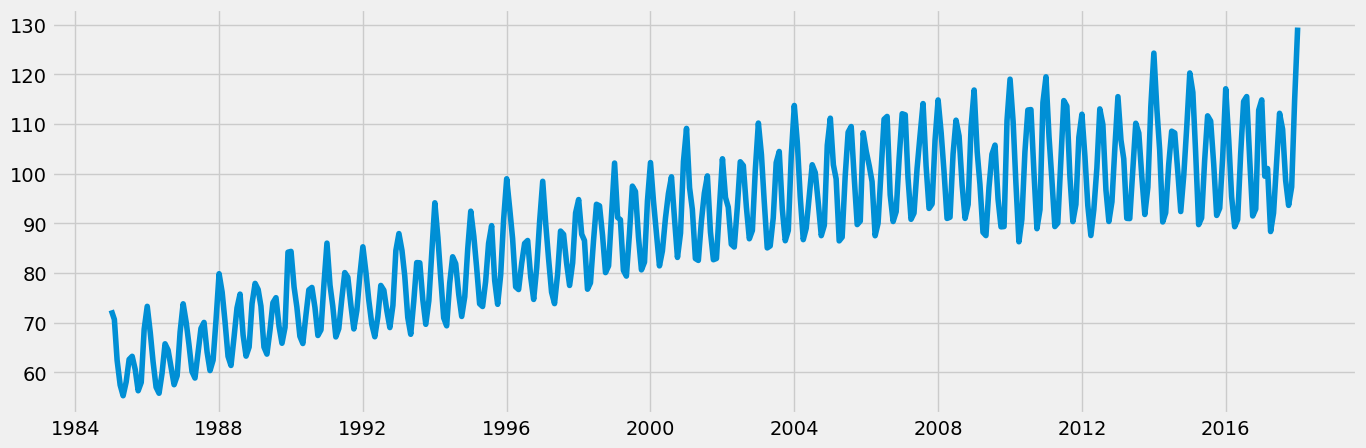

In [147]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df)

### 2. Subsetting, wrangling, and cleaning time-series data

In [189]:
# Reset index so that you can use the "Date" column as a filter

data_2 = df.reset_index()

In [191]:
data_2.head()

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [374]:
## Working with the last 17 years data:

data_sub = data_2.loc[(data_2['DATE'] >= '2013-01-01') & (data_2['DATE'] < '2017-12-01')]

In [376]:
data_sub.shape

(59, 2)

In [378]:
data_sub.head()

,DATE,IPG2211A2N
336,2013-01-01,115.5010
337,2013-02-01,106.7340
338,2013-03-01,102.9948
339,2013-04-01,91.0092
340,2013-05-01,90.9634


In [380]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['DATE']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['DATE'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,IPG2211A2N
datetime,
2013-01-01,115.5010
2013-02-01,106.7340
2013-03-01,102.9948
2013-04-01,91.0092
2013-05-01,90.9634


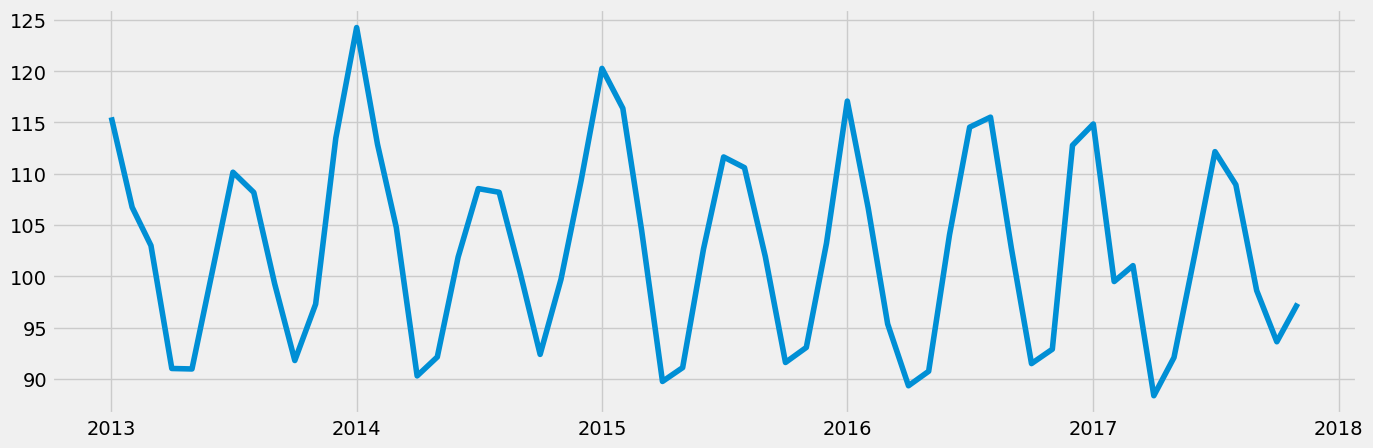

In [382]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [384]:
# Check for missing values
data_sub.isnull().sum() 

IPG2211A2N    0
dtype: int64

In [386]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [389]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [391]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

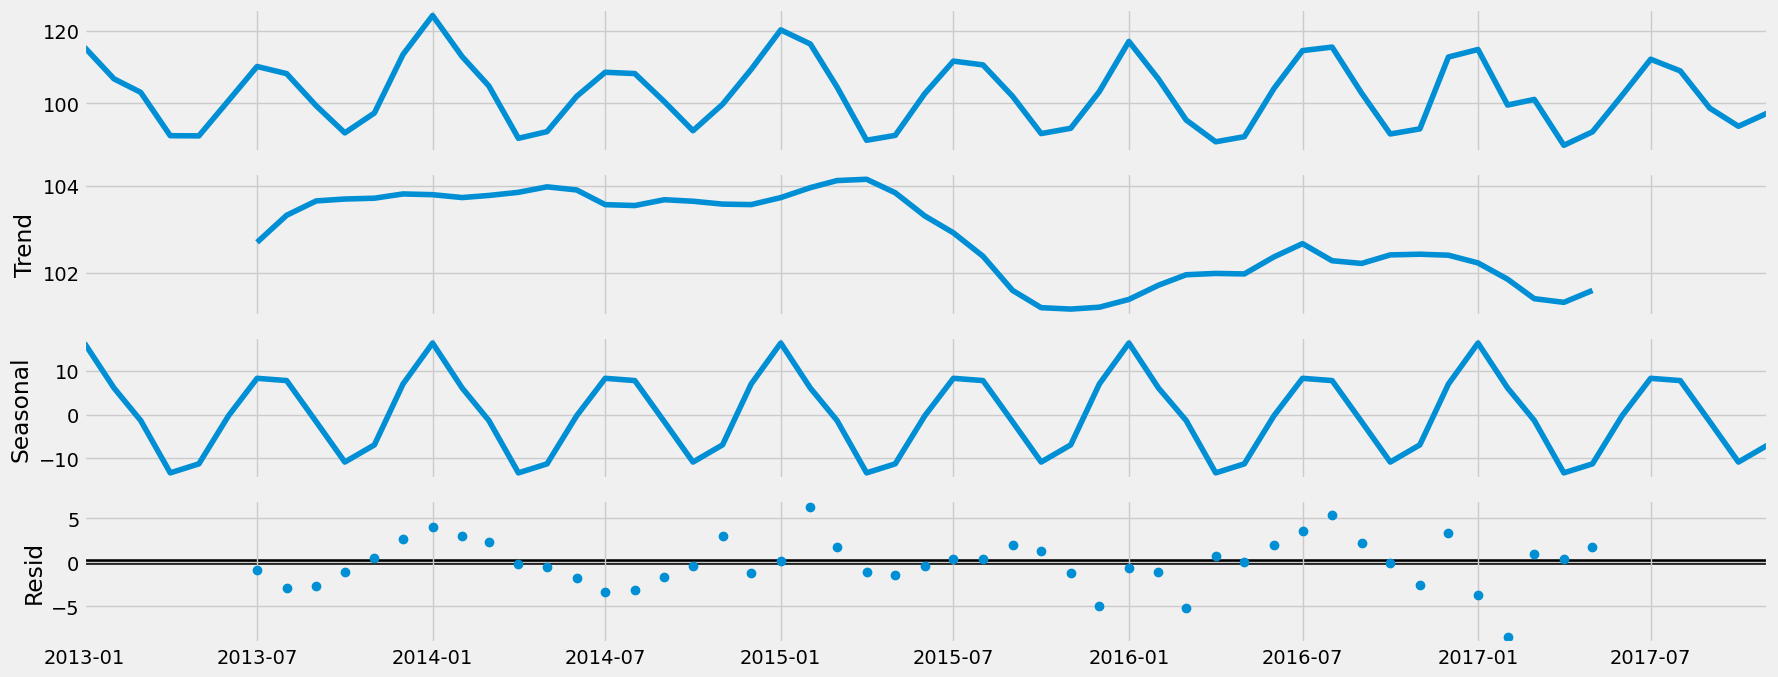

In [393]:
# Plot the separate components

decomposition.plot()
plt.show()

## Interpretation

The electricity production has a seasonal fluctuation which can be observed from both the raw data and the seasonal data. The trend plot shows that overall there is a general decline in the production of electricity. The residual plot shows that there are a few extreme values, however it appears they are not significantly large enough as these spikes correspond to the seasonal flucturations. 

### 4. Testing for stationarity

In [396]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['IPG2211A2N'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.056397
p-value                         0.732144
Number of Lags Used            11.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


## Interpretation: Dickey Fuller test:
Null hypothesis: the presence of a root unit.

Alternative hypothesis: there is no root unit 

The p-value (> 0.05) of the DF test shows that the data has non-stationarity. Hence, it is important to make the data stationary to proceed further. 

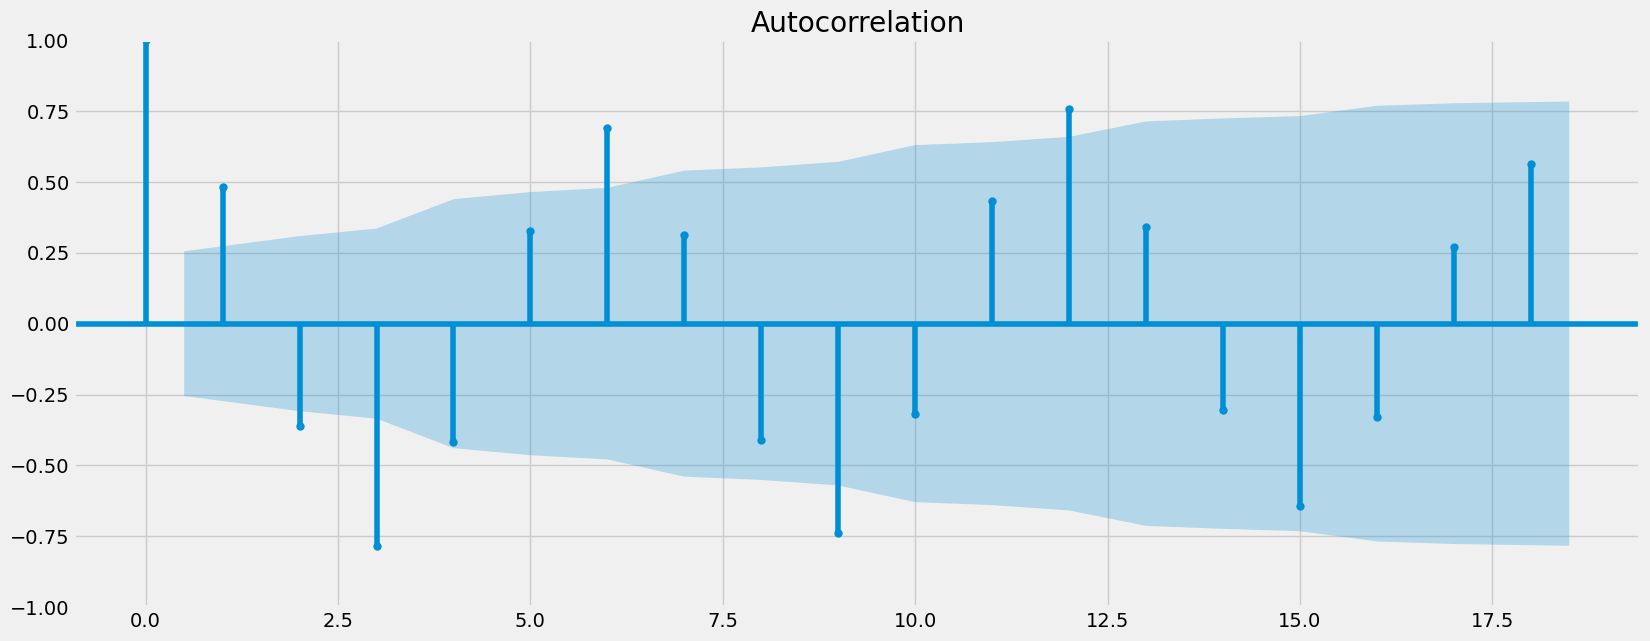

In [398]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

## Interpretation:

The spikes here says that there are certain data points that auto-correlate with the previous data. However, they are not more that 10. However, the DF test informs us that the data is non-stationary hence we should proceed further and make the data stationary. 

### 5. Stationarizing the Electric Production Dataset

In [401]:
## Performing stationarizing

data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [419]:
data_diff.dropna(inplace = True) 

# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [405]:
data_diff.head()

,IPG2211A2N
datetime,
2013-02-01,-8.7670
2013-03-01,-3.7392
2013-04-01,-11.9856
2013-05-01,-0.0458
2013-06-01,9.7323


In [407]:
data_diff.columns

Index(['IPG2211A2N'], dtype='object')

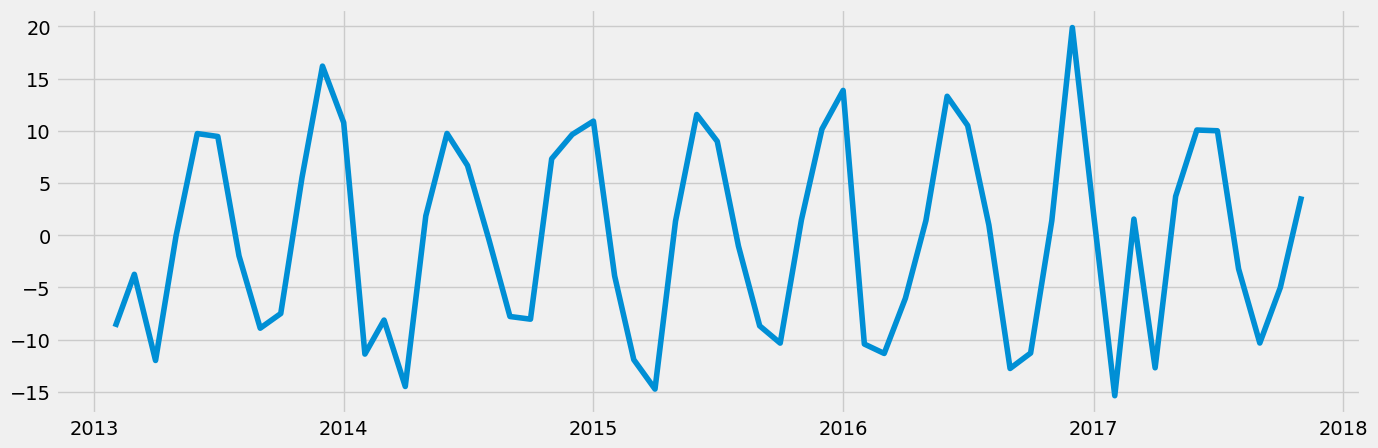

In [409]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [411]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.012255
p-value                         0.001348
Number of Lags Used            11.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


## Interpretation:

The DF test currently shows that the data is stationary as the p-value is less than 0.05. 

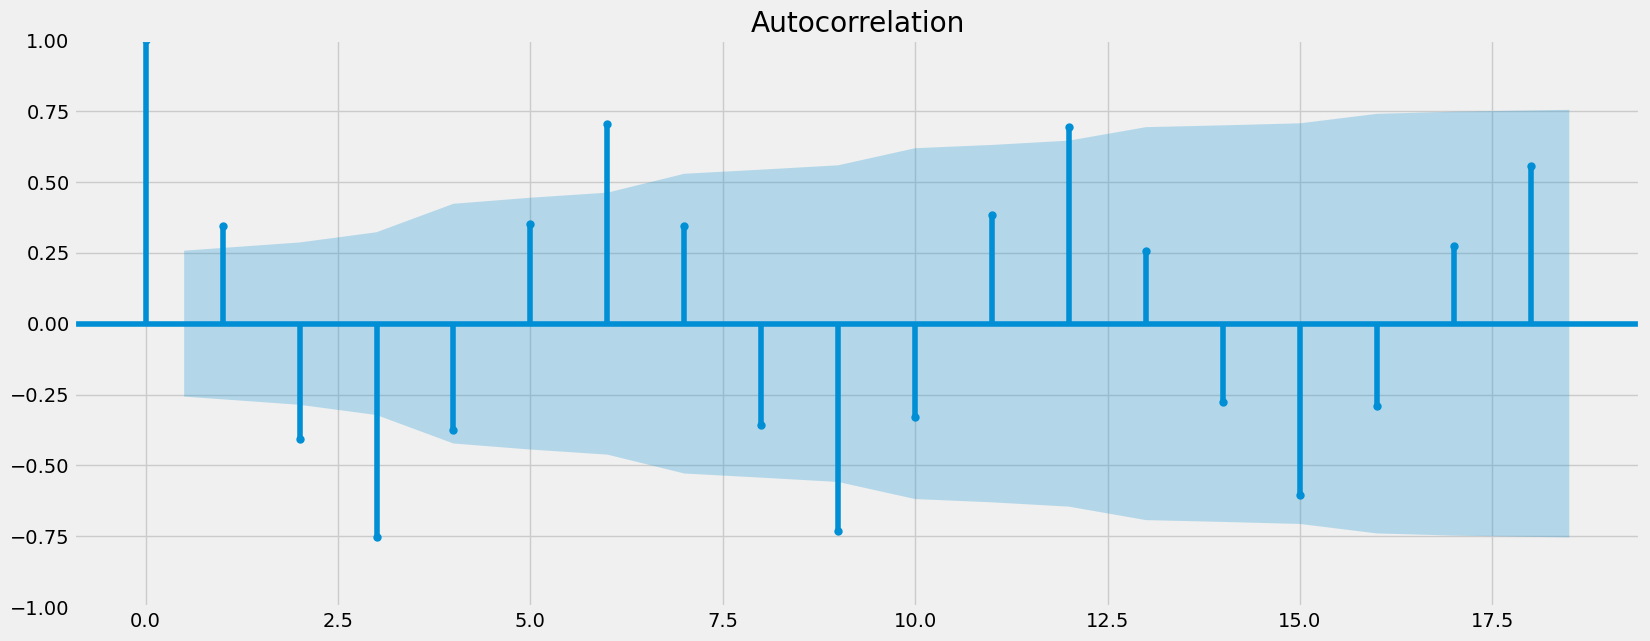

In [413]:
plot_acf(data_diff)
plt.show()

## Interpretation:

The auto-correlation plot has a few spikes showing that there is autocorrelation between the previous data. However, after performing stationarity, when the spikes are less than 10 (according to the material) we can proceed with the data for modeling. 